# Import all the required libraries

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('rec').getOrCreate()
from pyspark.sql.types import StructType
from pyspark.sql.functions import avg,count
from pyspark.sql import functions as sf

In [2]:
schema = StructType()
final_df = spark.createDataFrame([],schema)

# load dataframe from desktop

In [3]:
data = spark.read.csv(r'C:\Users\msasi\Downloads\paysim1\PS_log.csv',inferSchema = True,header = True)

# Create a view containing only records with STEP equals 1 or 2

In [4]:
data.createOrReplaceTempView("table1")
df = spark.sql("select * from table1 where step = 1 or step = 2")

# Group the datta with wrt nameOrig and then step and then Type

In [5]:
grouped_df = df.groupBy('nameOrig','step','type').count()

# Case 2 where the frequencies of the transaction type has to be filled up

In [9]:
case1_df = grouped_df.withColumn('joined_column',sf.concat(sf.lit('freq_of_'),sf.col('type'),sf.lit('_'), sf.col('step')))

In [19]:
case1_df = case1_df.select(['nameOrig','count','joined_column'])

## Below we are using Pivot to create the columns with desired naming convention

In [20]:
final_df = case1_df.groupBy('nameOrig').pivot('joined_column').count()

In [105]:
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.lower())

In [106]:
final_df.show()

+-----------+-----------------+-----------------+------------------+------------------+---------------+---------------+-----------------+-----------------+------------------+------------------+
|   nameorig|freq_of_cash_in_1|freq_of_cash_in_2|freq_of_cash_out_1|freq_of_cash_out_2|freq_of_debit_1|freq_of_debit_2|freq_of_payment_1|freq_of_payment_2|freq_of_transfer_1|freq_of_transfer_2|
+-----------+-----------------+-----------------+------------------+------------------+---------------+---------------+-----------------+-----------------+------------------+------------------+
|C1016856028|             null|             null|              null|              null|           null|           null|                1|             null|              null|              null|
|C1434932926|             null|             null|              null|              null|           null|           null|             null|                1|              null|              null|
| C577245010|             null

## CASE 3

In [15]:
#To check the schema of the table
final_df.printSchema()

root
 |-- nameOrig: string (nullable = true)
 |-- freq_of_CASH_IN_1: long (nullable = true)
 |-- freq_of_CASH_IN_2: long (nullable = true)
 |-- freq_of_CASH_OUT_1: long (nullable = true)
 |-- freq_of_CASH_OUT_2: long (nullable = true)
 |-- freq_of_DEBIT_1: long (nullable = true)
 |-- freq_of_DEBIT_2: long (nullable = true)
 |-- freq_of_PAYMENT_1: long (nullable = true)
 |-- freq_of_PAYMENT_2: long (nullable = true)
 |-- freq_of_TRANSFER_1: long (nullable = true)
 |-- freq_of_TRANSFER_2: long (nullable = true)



## For this case I computed the sum of all old balances and new balances for the nameOrig and then the difference to know how much net they spent at each STEP. Note that there isn't any timestamp due to which I came up with this solution

In [84]:
case3_df_initial = data.groupBy('nameOrig','step').sum('oldbalanceOrg','newbalanceOrig')
case3_df = case3_df_initial.withColumn('Balance_step_number',sf.concat(sf.lit('Balance_step_'),sf.col('step')))
case3_final = case3_df.withColumn("Balance_step", sf.col('sum(oldbalanceOrg)') - sf.col('sum(newbalanceOrig)'))

In [85]:
case3_final.show()

+-----------+----+------------------+-------------------+-------------------+-------------------+
|   nameOrig|step|sum(oldbalanceOrg)|sum(newbalanceOrig)|Balance_step_number|       Balance_step|
+-----------+----+------------------+-------------------+-------------------+-------------------+
| C221861886|   1|           24866.0|           23768.26|     Balance_step_1| 1097.7400000000016|
|C1423016050|   1|           52951.0|           48531.96|     Balance_step_1|  4419.040000000001|
| C977160959|   1|               0.0|                0.0|     Balance_step_1|                0.0|
| C270661321|   1|             666.0|                0.0|     Balance_step_1|              666.0|
|C1717433286|   1|        1508076.41|         1888091.55|     Balance_step_1|-380015.14000000013|
|C1395073533|   1|         476683.72|          315983.22|     Balance_step_1|           160700.5|
| C254918854|   1|               0.0|                0.0|     Balance_step_1|                0.0|
| C780843029|   1|  

In [86]:
case3_final_result = case3_final['nameOrig','Balance_step_number','Balance_step']

In [87]:
case3_final_result.show()

+-----------+-------------------+-------------------+
|   nameOrig|Balance_step_number|       Balance_step|
+-----------+-------------------+-------------------+
| C221861886|     Balance_step_1| 1097.7400000000016|
|C1423016050|     Balance_step_1|  4419.040000000001|
| C977160959|     Balance_step_1|                0.0|
| C270661321|     Balance_step_1|              666.0|
|C1717433286|     Balance_step_1|-380015.14000000013|
|C1395073533|     Balance_step_1|           160700.5|
| C254918854|     Balance_step_1|                0.0|
| C780843029|     Balance_step_1|                0.0|
| C302987494|     Balance_step_1|              164.0|
|C1540476618|     Balance_step_1| -35492.20000000001|
|C1144897090|     Balance_step_1| -31646.30999999959|
| C226586078|     Balance_step_1| -42922.80999999959|
|  C94748968|     Balance_step_1|                0.0|
|C1773336805|     Balance_step_1|            3857.29|
| C941453849|     Balance_step_1| 3236.8600000000006|
| C987015126|     Balance_st

In [ ]:
for col in case3_final_result.columns:
    case3_final_result = case3_final_result.withColumnRenamed(col, col.lower())

# CASE 4

### average_transaction_amount_to_merchantdestinationaccount_step_* - average transaction amount transferred to merchant accounts (starting with M in destination account) in steps (1,2)
### For this part I have also added the nameDest column to the final set of columns

In [89]:
case4_df = df.select(['nameOrig','amount', 'nameDest','step'])

In [90]:
case4_df.show()

+-----------+---------+-----------+----+
|   nameOrig|   amount|   nameDest|step|
+-----------+---------+-----------+----+
|C1231006815|  9839.64|M1979787155|   1|
|C1666544295|  1864.28|M2044282225|   1|
|C1305486145|    181.0| C553264065|   1|
| C840083671|    181.0|  C38997010|   1|
|C2048537720| 11668.14|M1230701703|   1|
|  C90045638|  7817.71| M573487274|   1|
| C154988899|  7107.77| M408069119|   1|
|C1912850431|  7861.64| M633326333|   1|
|C1265012928|  4024.36|M1176932104|   1|
| C712410124|  5337.77| C195600860|   1|
|C1900366749|  9644.94| C997608398|   1|
| C249177573|  3099.97|M2096539129|   1|
|C1648232591|  2560.74| M972865270|   1|
|C1716932897| 11633.76| M801569151|   1|
|C1026483832|  4098.78|M1635378213|   1|
| C905080434|229133.94| C476402209|   1|
| C761750706|  1563.82|M1731217984|   1|
|C1237762639|  1157.86|M1877062907|   1|
|C2033524545|   671.64| M473053293|   1|
|C1670993182| 215310.3|C1100439041|   1|
+-----------+---------+-----------+----+
only showing top

## From the above table we have to select only the records where nameDest starts wiht M as in Merchant

In [91]:
case4_df.createOrReplaceTempView("table2")
df_for_case4 = spark.sql("select * from table2 where nameDest LIKE 'M%'")
#This can also be done using Filter fuction
#df_for_case4 = case4_df.filter()

In [92]:
df_for_case4.show()

+-----------+--------+-----------+----+
|   nameOrig|  amount|   nameDest|step|
+-----------+--------+-----------+----+
|C1231006815| 9839.64|M1979787155|   1|
|C1666544295| 1864.28|M2044282225|   1|
|C2048537720|11668.14|M1230701703|   1|
|  C90045638| 7817.71| M573487274|   1|
| C154988899| 7107.77| M408069119|   1|
|C1912850431| 7861.64| M633326333|   1|
|C1265012928| 4024.36|M1176932104|   1|
| C249177573| 3099.97|M2096539129|   1|
|C1648232591| 2560.74| M972865270|   1|
|C1716932897|11633.76| M801569151|   1|
|C1026483832| 4098.78|M1635378213|   1|
| C761750706| 1563.82|M1731217984|   1|
|C1237762639| 1157.86|M1877062907|   1|
|C2033524545|  671.64| M473053293|   1|
|  C20804602| 1373.43|M1344519051|   1|
| C504336483| 3876.41|M1404932042|   1|
|C1043358826| 6061.13|M1558079303|   1|
|C1671590089| 9478.39|  M58488213|   1|
|C1053967012| 8009.09| M295304806|   1|
|C1632497828| 8901.99|  M33419717|   1|
+-----------+--------+-----------+----+
only showing top 20 rows



In [93]:
#average_transaction_amount_to_merchantdestinationaccount_step_* 
case4_df_final = df_for_case4.withColumn('joined_column',sf.concat(sf.lit('average_transactions_amount_to_merchantdestinationacccount_step_'),sf.col('step')))

In [94]:
case4_df_final.show()

+-----------+--------+-----------+----+--------------------+
|   nameOrig|  amount|   nameDest|step|       joined_column|
+-----------+--------+-----------+----+--------------------+
|C1231006815| 9839.64|M1979787155|   1|average_transacti...|
|C1666544295| 1864.28|M2044282225|   1|average_transacti...|
|C2048537720|11668.14|M1230701703|   1|average_transacti...|
|  C90045638| 7817.71| M573487274|   1|average_transacti...|
| C154988899| 7107.77| M408069119|   1|average_transacti...|
|C1912850431| 7861.64| M633326333|   1|average_transacti...|
|C1265012928| 4024.36|M1176932104|   1|average_transacti...|
| C249177573| 3099.97|M2096539129|   1|average_transacti...|
|C1648232591| 2560.74| M972865270|   1|average_transacti...|
|C1716932897|11633.76| M801569151|   1|average_transacti...|
|C1026483832| 4098.78|M1635378213|   1|average_transacti...|
| C761750706| 1563.82|M1731217984|   1|average_transacti...|
|C1237762639| 1157.86|M1877062907|   1|average_transacti...|
|C2033524545|  671.64| M

In [95]:
case4_df_final_result = case4_df_final.groupBy('nameOrig','nameDest').pivot('joined_column').avg('amount')

In [96]:
case4_df_final_result.show()

+-----------+-----------+-----------------------------------------------------------------+-----------------------------------------------------------------+
|   nameOrig|   nameDest|average_transactions_amount_to_merchantdestinationacccount_step_1|average_transactions_amount_to_merchantdestinationacccount_step_2|
+-----------+-----------+-----------------------------------------------------------------+-----------------------------------------------------------------+
| C504336483|M1404932042|                                                          3876.41|                                                             null|
| C335466988|M1640244246|                                                          4209.87|                                                             null|
|C1338229093| M278986288|                                                             null|                                                           311.38|
| C623051334|M1340051218|                           

In [97]:
for col in case4_df_final_result.columns:
    case4_df_final_result = case4_df_final_result.withColumnRenamed(col, col.lower())

# Joining dataframes. For this purpose I have used Inner Join as only the common records from all these tables are of interest for us. (this is an assumption that I made, if need be other joins can be carried out similarly).

In [107]:
ta = final_df.alias('ta')
tb = case3_final_result.alias('tb')
tc = case4_df_final_result.alias('tc')

inner_join = ta.join(tb, ta.nameorig == tb.nameorig).drop(tb.nameorig).join(tc, ta.nameorig == tc.nameorig).drop(tc.nameorig)
#inner_join.show()

# The below schema is exactly how the table MUST be created in Cassandra with nameOrig as the Primary key

In [110]:
inner_join.printSchema()

root
 |-- nameorig: string (nullable = true)
 |-- freq_of_cash_in_1: long (nullable = true)
 |-- freq_of_cash_in_2: long (nullable = true)
 |-- freq_of_cash_out_1: long (nullable = true)
 |-- freq_of_cash_out_2: long (nullable = true)
 |-- freq_of_debit_1: long (nullable = true)
 |-- freq_of_debit_2: long (nullable = true)
 |-- freq_of_payment_1: long (nullable = true)
 |-- freq_of_payment_2: long (nullable = true)
 |-- freq_of_transfer_1: long (nullable = true)
 |-- freq_of_transfer_2: long (nullable = true)
 |-- balance_step_number: string (nullable = true)
 |-- balance_step: double (nullable = true)
 |-- namedest: string (nullable = true)
 |-- average_transactions_amount_to_merchantdestinationacccount_step_1: double (nullable = true)
 |-- average_transactions_amount_to_merchantdestinationacccount_step_2: double (nullable = true)



# WRITITNG DATA INTO CASSANDRA

In [ ]:
inner_join.write\
.format("org.apache.spark.sql.cassandra")\
.mode('append')\
.options(table="final_result_trial", keyspace="demodb")\
.save()

# In CQL Command line execute the following commands
#### CQLSH> USE demodb;
#### CQLSH> CREATE TABLE final_result_trial(...);
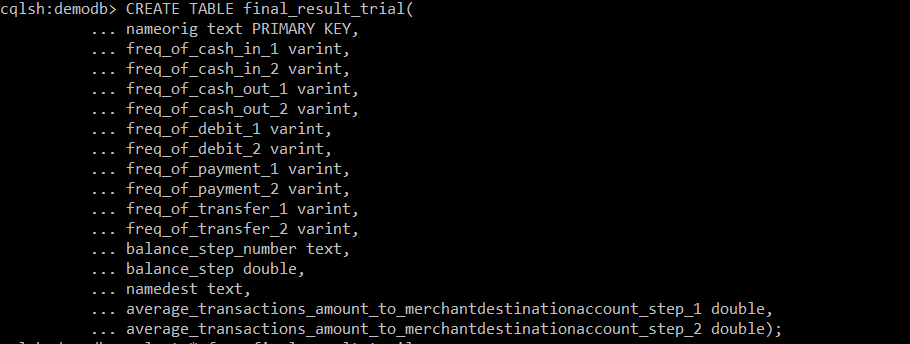

# Open up a spark terminal and run the following command to submit the spark job

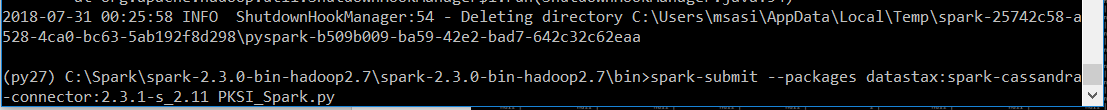



# The end result after spark job can be verified by running the following query

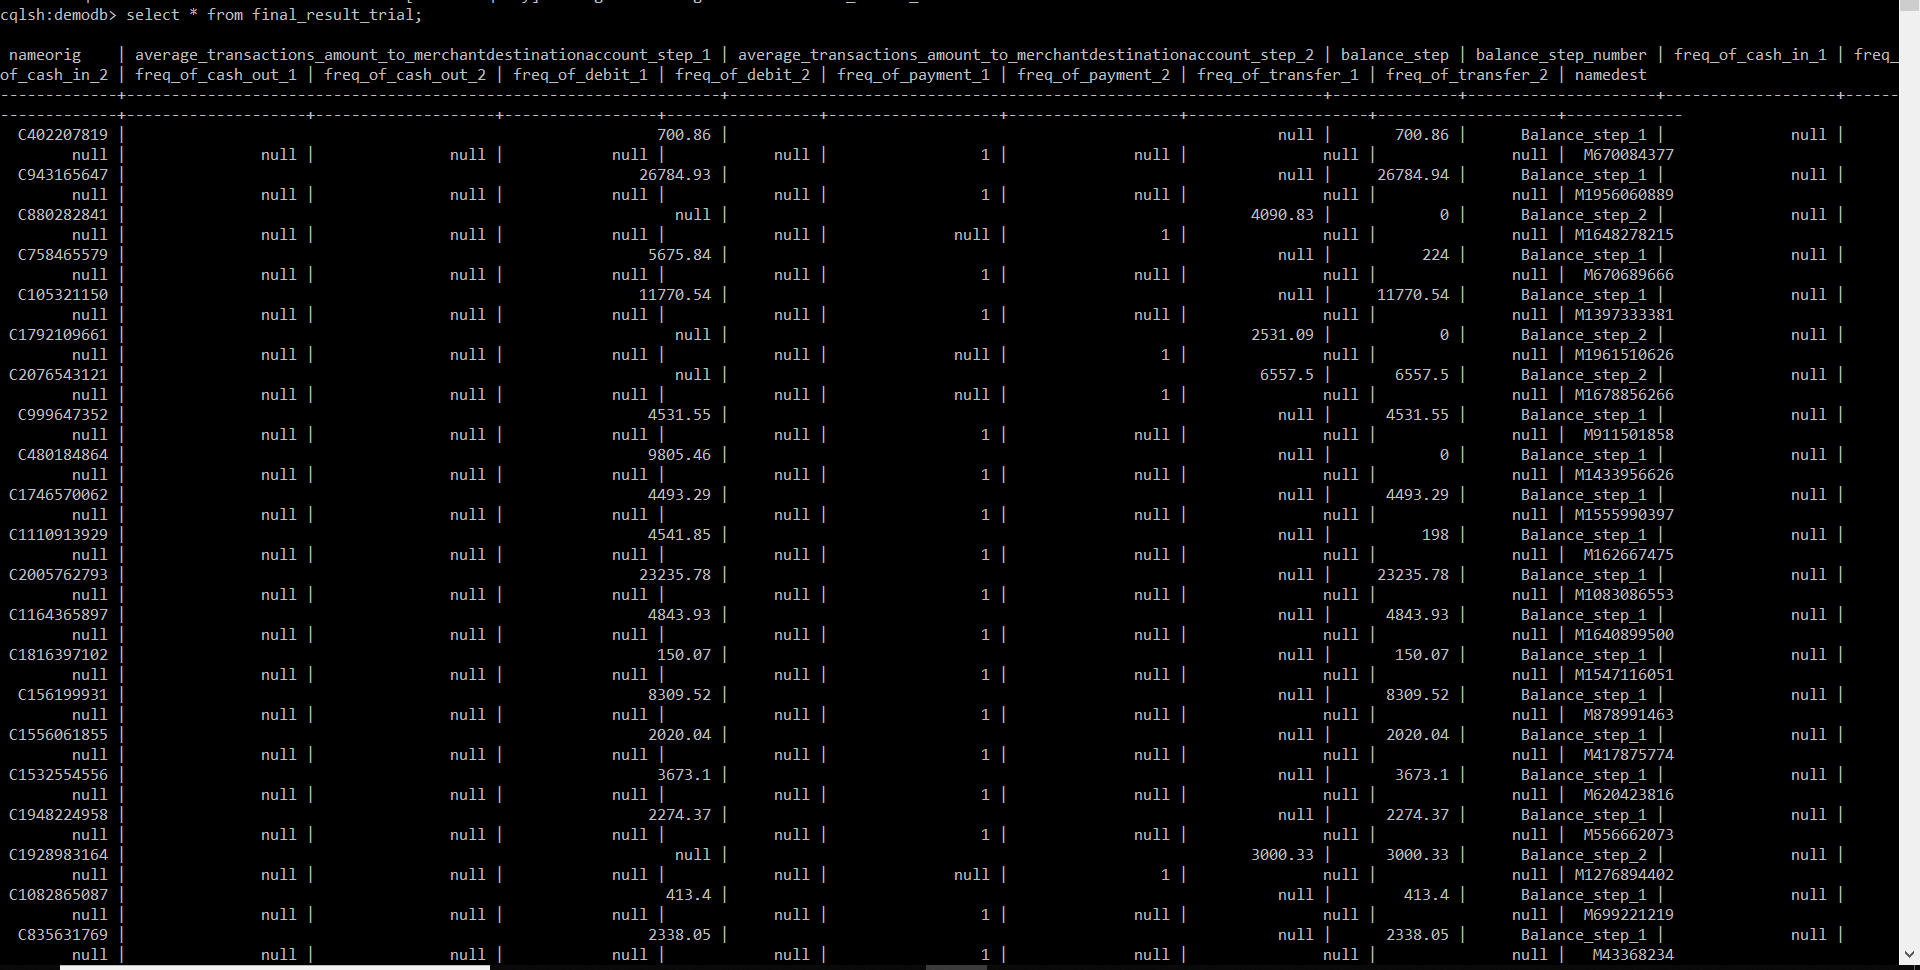